# Machine Learning in Crowd Modelling and Simulation

In this task we implement a crowd simulation model using the cellular automata approach.
Our implementation can be run either by loading saved scenario files which are based on csv files or by the user detailing their own scenario.

Before moving ahead we import the key packages. It is best to install the required packages as detailed in the
`README.md` file with the help of the provided `requirements.txt` file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from utilities import parser_array2obj
from visualization import visualize_state
from main import crowd_simulator
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

pygame 2.0.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Some conventions
Throughout this notebook and in the simulations we will follow some labelling conventions for clarity. These are listen in the table below:

|Numerical Encoding|Description|Color Assignment in GUI and visualizations| |
|---|---|---|---|
|0|Empty Cell| <span style="color:black">Black</span> / <span style="color:blue">Blue</span>.  ||
|1|Pedestrian|  <span style="color:red">Red</span>. | |
|2|Obstacle| <span style="color:yellow">Yellow</span>.  |   |
|3|Target|  <span style="color:green">Green</span>. ||


# Task 1: The setup

It is possible to execute the crowd simulator in two ways. The first is to simply execute the `main.py` file i.e. `python3 main.py` and then following the instructions on the CLI. The second method is to execute it by calling the appropriate function and methods in the jupyter notebook environment. In order to show the functionality of the simulator, we will first make use of the pygame GUI. In subsequent tasks, since we wish to show states and specific plots, we will use the jupyter notebook environment to run the simulations.

Here the user has two options

### Option 1: Load scenario
If you wish to load a scenario then type y in the following cell block. A list of available scenarios will be printed. Enter the id number of the scenario you wish to load and this will be loaded into a variable.


### Option 2: Make customer scenario
If you wish to make own scenario then type n in the following cell block. You will be asked for the size of the grid you wish to generate. Enter the row and column numbers. Finally a GUI will pop up. You can make a scenario there. Type in `P` to add a pedestrian, `O` for object and `T` for target. Please note all of these need to be in **upper case**. If you wish for a cell to remain empty you can leave it as it is. Once you are finished simply close the GUI. The scenario will be saved in a variable for further processing. 


In [ ]:
crowd_simulator()

 Leave answers empty for default 
Do you want to load a scenario? (y/n)y
Available scenario files are: 
Scenario 0 :  rimea_test4.csv
Scenario 1 :  task_3.csv
Scenario 2 :  rimea_test6.csv
Scenario 3 :  task_4_no_obst.csv
Scenario 4 :  chicken_test_multi_peds.csv
Scenario 5 :  task_4.csv
Scenario 6 :  chicken_test.csv
Scenario 7 :  multiple_targets.csv
Scenario 8 :  rimea_test1.csv
Scenario 9 :  ped_after_ped.csv
Scenario 10 :  task_2.csv
Scenario 11 :  .~lock.task_4.csv#
Please select which scenario you wish to load. Enter scenario id:1
Initial state of the loaded scenario:
Would you like to use Dijkstra-algorithm? (y/n)n
Maximum number of steps: (Positive integer)10
2 32 0.71 -0.71 1
2 32 1.42 -1.42 1
2 32 MOVED
3 31 1.13 -1.29 1
3 31 MOVED
4 30 0.8399999999999999 -1.42 1
4 30 1.5499999999999998 -2.13 1
4 30 MOVED
5 29 1.2599999999999998 -1.58 1
5 29 MOVED
6 28 0.9699999999999998 -1.13 1
6 28 1.6799999999999997 -1.8399999999999999 1
6 28 MOVED


# Task 2: Single Pedestrian

0.8399999999999999

### The simulation
We will now simulate the loaded scenario with our simple update step i.e. rudementary obstical avoidance and pedestrian repulsion. The scenario is such that we have a grid of 50x50 cells and a pedestrian at position (5,25) and a target at (25,25). Let us see how the pedestrian progresses.

**NOTE: This simulation can also be executed using the pygame GUI. Simply select load scenario and select the task_1.csv scenario file.**
The results will be visualized with the help of a matplotlib animation. The initial state of the scenario is shown below:

In [ ]:
with open('./scenarios/task_2.csv', newline='') as csvfile:
    task_2 = np.array(list(csv.reader(csvfile))).astype(int)
    task_2 = parser_array2obj(task_2)
visualize_state(task_2.to_array())

**Let us simulate this for 25 steps and animate**

In [ ]:
task_2.simulate(25)
task_2.animate()

### Observations

In this simple case, we use the distance of cells to the target as our cost operator for the pedestrian to decide their next move. A visualization of the cost can be seen below:

In [ ]:
fig = plt.figure()
cost_task_2 = task_2.get_distance_to_target()
plt.imshow(cost_task_2)
plt.colorbar()
plt.title("Distance to Target as a color map representation")

# Task 3: Pedestrian Interaction

In this task we will show how pedestrians interact with each other in a  given scenario.
In order to model the pedestrian interaction we use the following formula for modelling repulsion:

### cost = $\frac{1}{e(r^2 - r_{max}^2)}$

In [ ]:
x = np.arange(0,10,0.1)
y = 1/np.exp(x**2 - 1.5**2)
fig, ax = plt.subplots(1,1)
ax.plot(x,y)
ax.set_ylabel('cost')
ax.set_xlabel('distance between pedestrians')
plt.show()

In [ ]:
with open('./scenarios/task_3.csv', newline='') as csvfile:
    task_3 = np.array(list(csv.reader(csvfile))).astype(int)
    task_3 = parser_array2obj(task_3)
visualize_state(task_3.to_array())

In [ ]:
task_3.simulate(50, absorbing_targets=False)
task_3.animate()

# Task 4: Obstacle Avoidance 

### Without Obstacle Avoidance

We see that as expected, without obstacle avoidance, the pedestrians simply break the obstacle barrier and go through it. This is ofcourse not natural behavior (unless the pedestrians are really strong ;) ) Hence we will apply some basic obstacle avoidance.

Note that we conduct the bottleneck experiment with a lesser number of pedestrians as simulating 150 pedestrians was too expensive for our simulator.

<IPython.core.display.Javascript object>


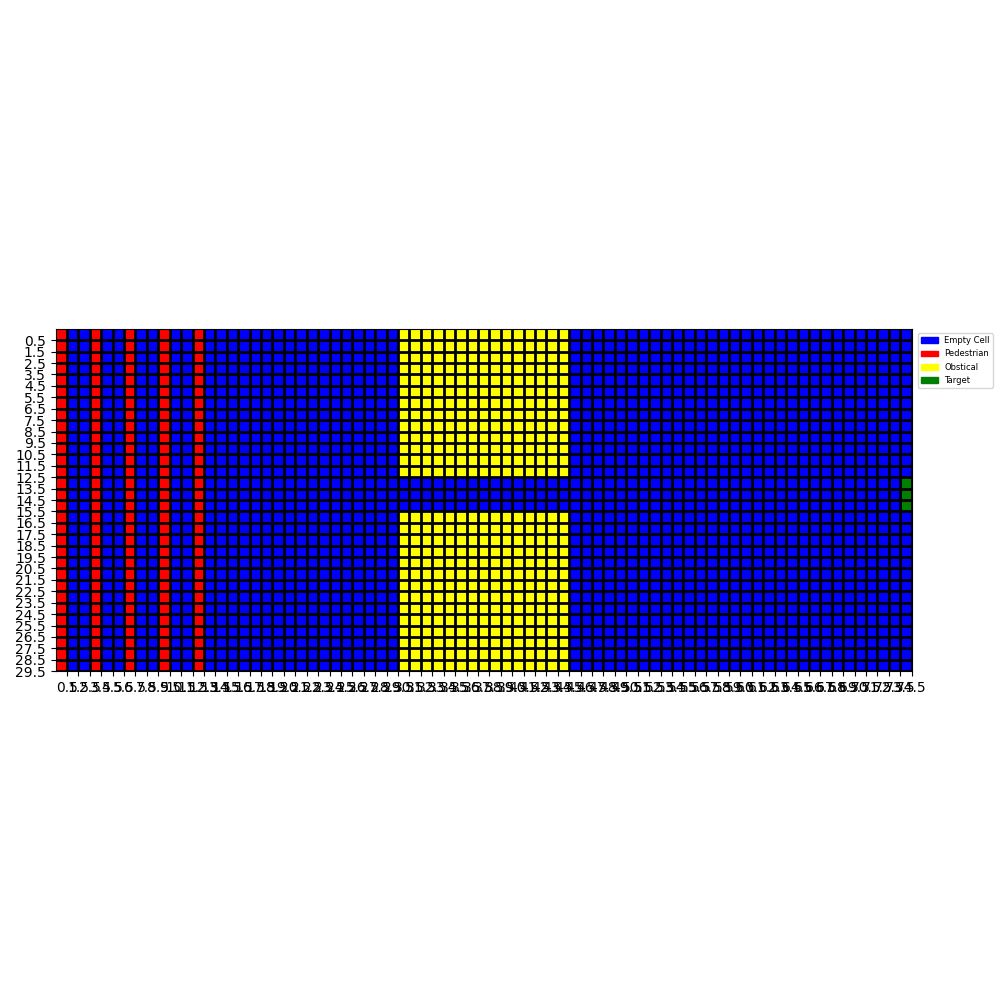

In [11]:
with open('./scenarios/task_4.csv', newline='') as csvfile:
    task_4 = np.array(list(csv.reader(csvfile))).astype(int)
    task_4 = parser_array2obj(task_4, obstacle_avoidance=False)
visualize_state(task_4.to_array())

The simulation was took 76 steps and was executed in 22.8 seconds.


<IPython.core.display.Javascript object>


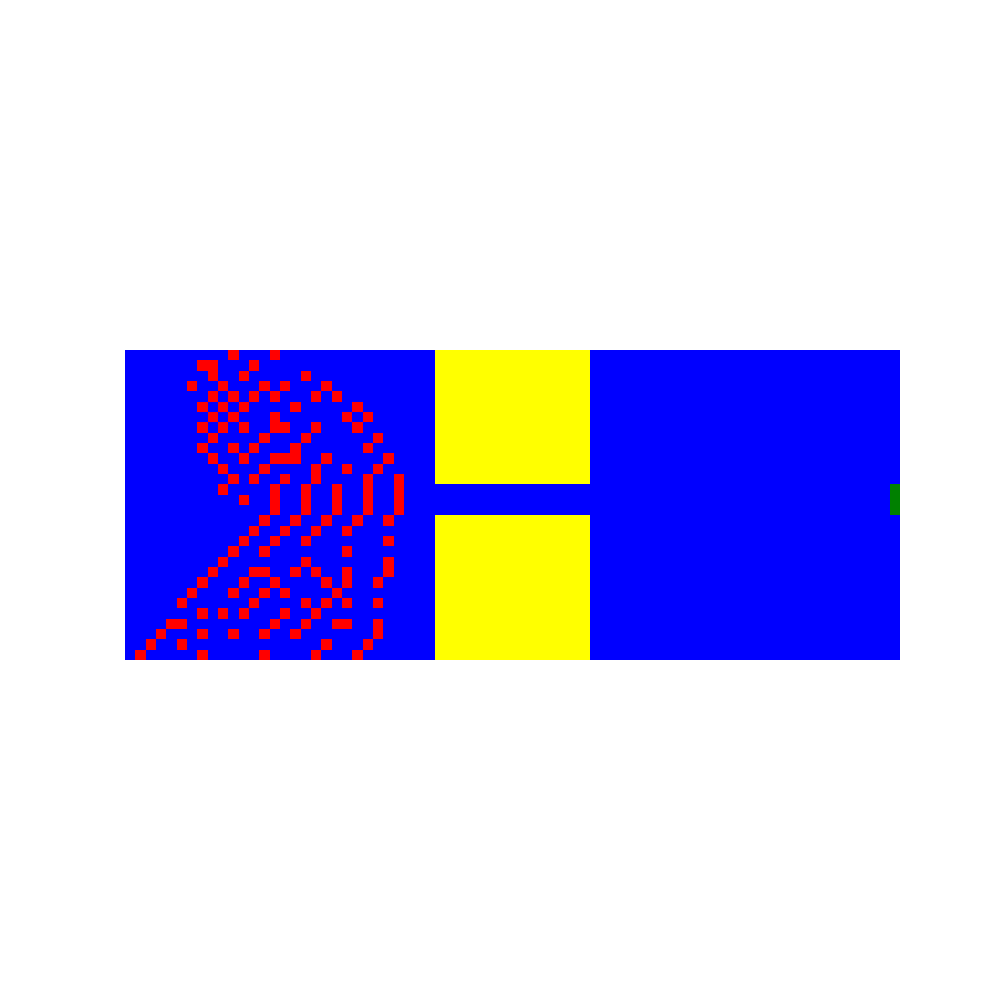

In [12]:
task_4.simulate(75, obstacle_avoidance=False)
task_4.animate()

### Rudementary Obstacle Avoidance

We have now implemented some basic obstacle avoidance which is as simple as setting a rule that pedestrians should not step into a cell that is classified as an obstacle. This is done by assigning the obstacle cells with a very high cost. 

We can observe that now the pedestrians follow a more "Natural" behavior and do not barge through obstacles as they did before.

<IPython.core.display.Javascript object>


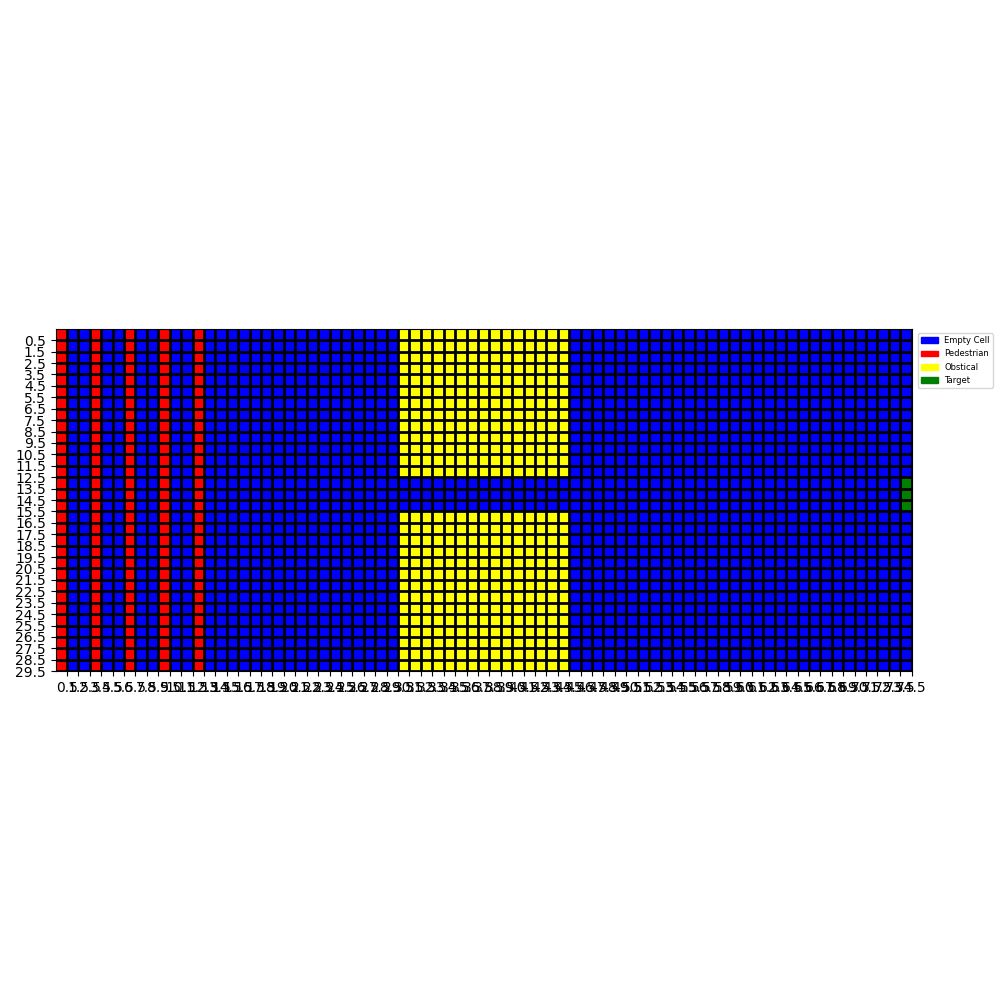

In [6]:
with open('./scenarios/task_4.csv', newline='') as csvfile:
    task_4 = np.array(list(csv.reader(csvfile))).astype(int)
    task_4 = parser_array2obj(task_4)
visualize_state(task_4.to_array())

The simulation was took 66 steps and was executed in 19.8 seconds.


<IPython.core.display.Javascript object>


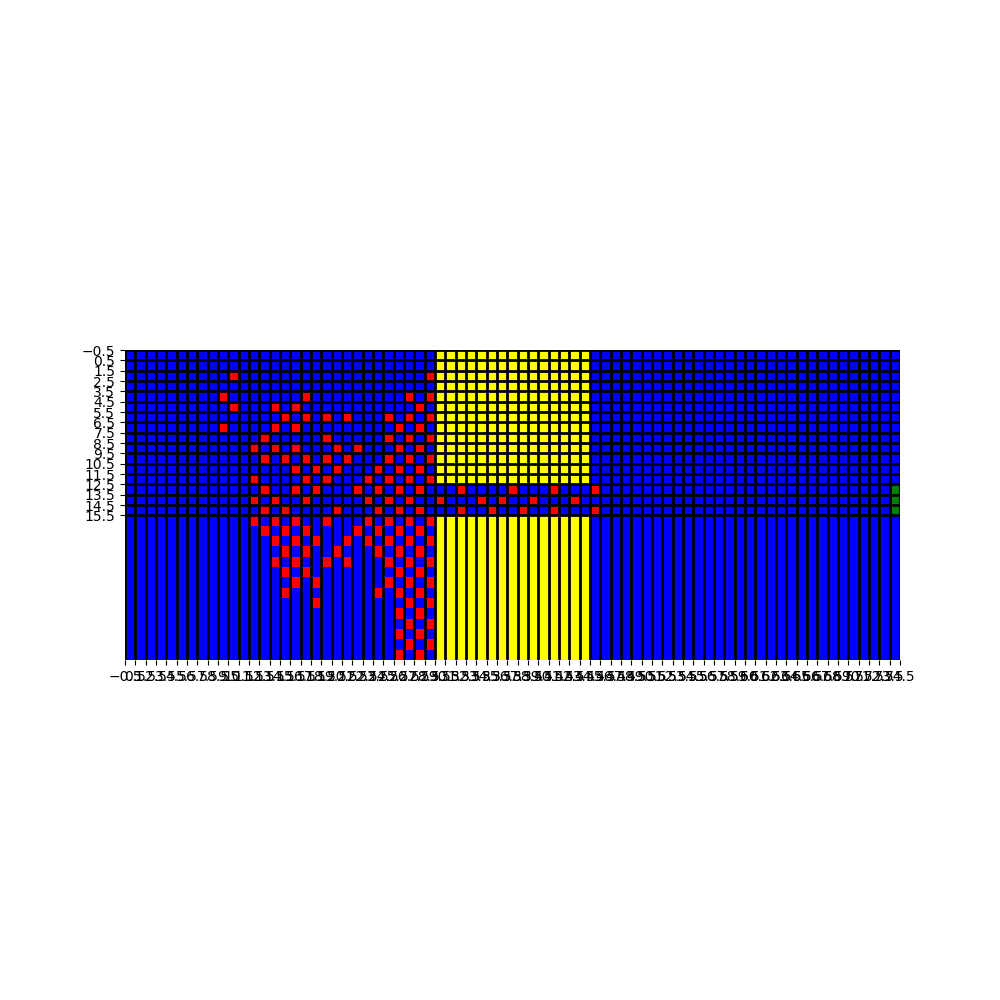

In [7]:
task_4.simulate(65, dijkstra=False)
task_4.animate()

0.5499999999999998

### The Chicken Test
Rudementary obstacle avoidance implemented, we see how our simulator now performs on the chicken test with 1 pedestrian only.

In [ ]:
with open('./scenarios/chicken_test.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)
visualize_state(chicken_test.to_array())

**As expected, our poor pedestrian gets stuck in the trap because the cells simply have a cost which does not take into account how paths are connected.**

In [ ]:
chicken_test.simulate(25, dijkstra=False)
chicken_test.animate()

### The Dijkstra's Algorithm
We implement the Dijkstra's algorithm to flood the cells with utilitiy values starting from the targets i.e. targets have a cost of 0. 

This allows a kind of look ahead when we simulate our pedestrians since now we have also taken into account the obsticals. Essentially the entire grid is treated as a well connected bi-directional graph instead of the points where the obsticals exist. These cells are treated as unconnected nodes on the graph. This is shown below:

<table>
  <tr>
    <td><img src="./figures/fully_connected.png" width=270 height=480></td>
    <td><img src="./figures/graph_with_obj.png" width=270 height=480></td>
  </tr>
      <tr>
    <td>Fully Connected Bi-Directional Graph</td>
     <td>Bi-directional Graph with Obstacle </td>
  </tr>
 </table>


### Chicken Test Part 2: The dijkstra's algorithm
We now plot the cell costs that are calculated with the help of the dijkstra's algorithm with the target cell(s) having a cost of 0. This is represented in the color map of the chicken test below

<IPython.core.display.Javascript object>


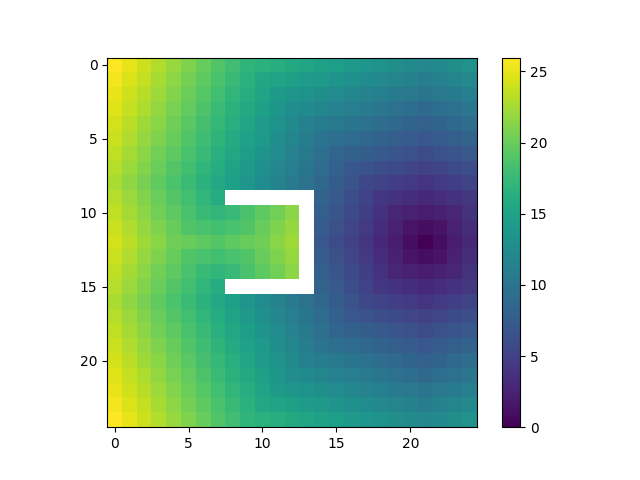

The simulation was took 2 steps and was executed in 0.6 seconds.


In [8]:
with open('./scenarios/chicken_test.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)

fig = plt.figure()
chicken_test.simulate(1, dijkstra=True)
plt.imshow(chicken_test.get_dijkstra())
plt.colorbar()

Let us now simulate the chicken test again this time with the dikstra's algorithm

The simulation was took 26 steps and was executed in 7.8 seconds.


<IPython.core.display.Javascript object>


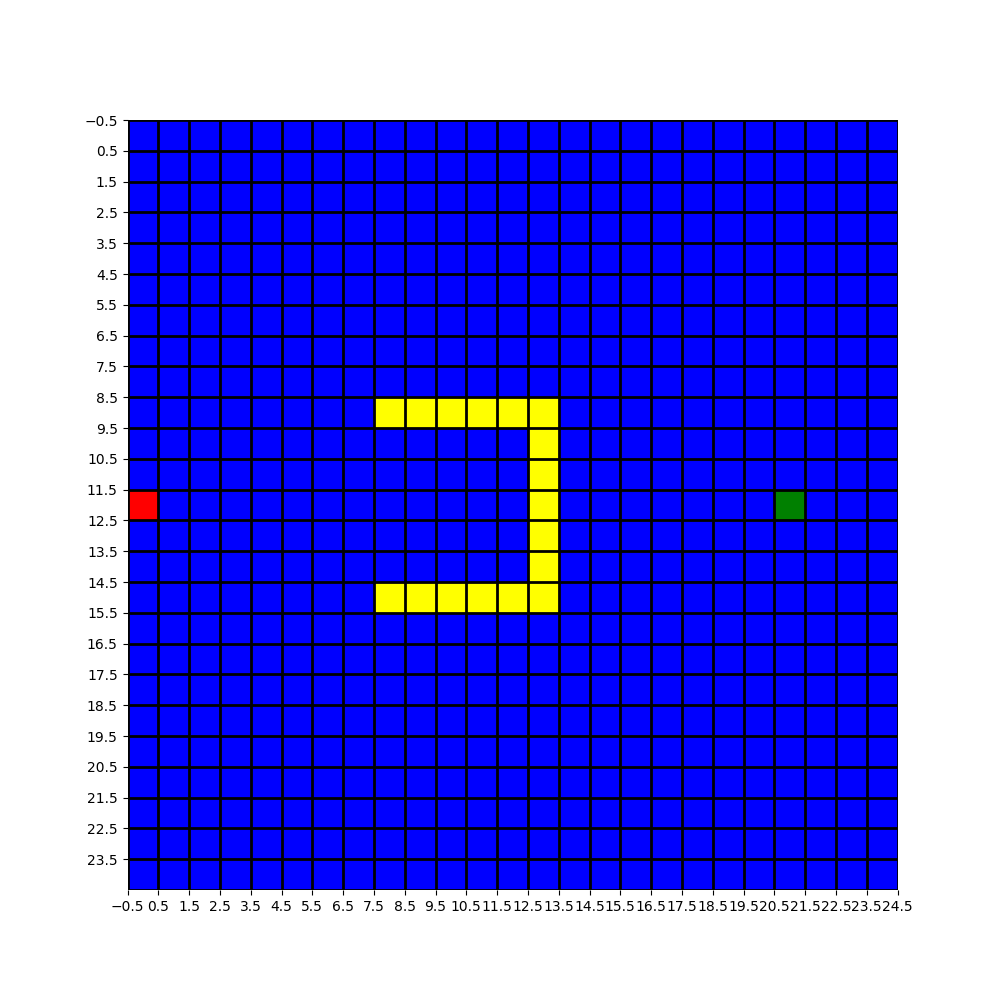

In [9]:
chicken_test.simulate(25, dijkstra=True)
chicken_test.animate()

# Task 5: Integration Testing - RiMEA Scenarios

### RiMEA 1
In this test we need to assess if the speed at which a certain pedestrian walks towards the target translates to an accurate simulation time. the scenario is a 40m by 10m corridor. We model each cell as 0.4m and the pedestrian as 0.4m as well so that the pedestrian occupipes 1 cell. 

We first visualize the scenario as always.

<IPython.core.display.Javascript object>


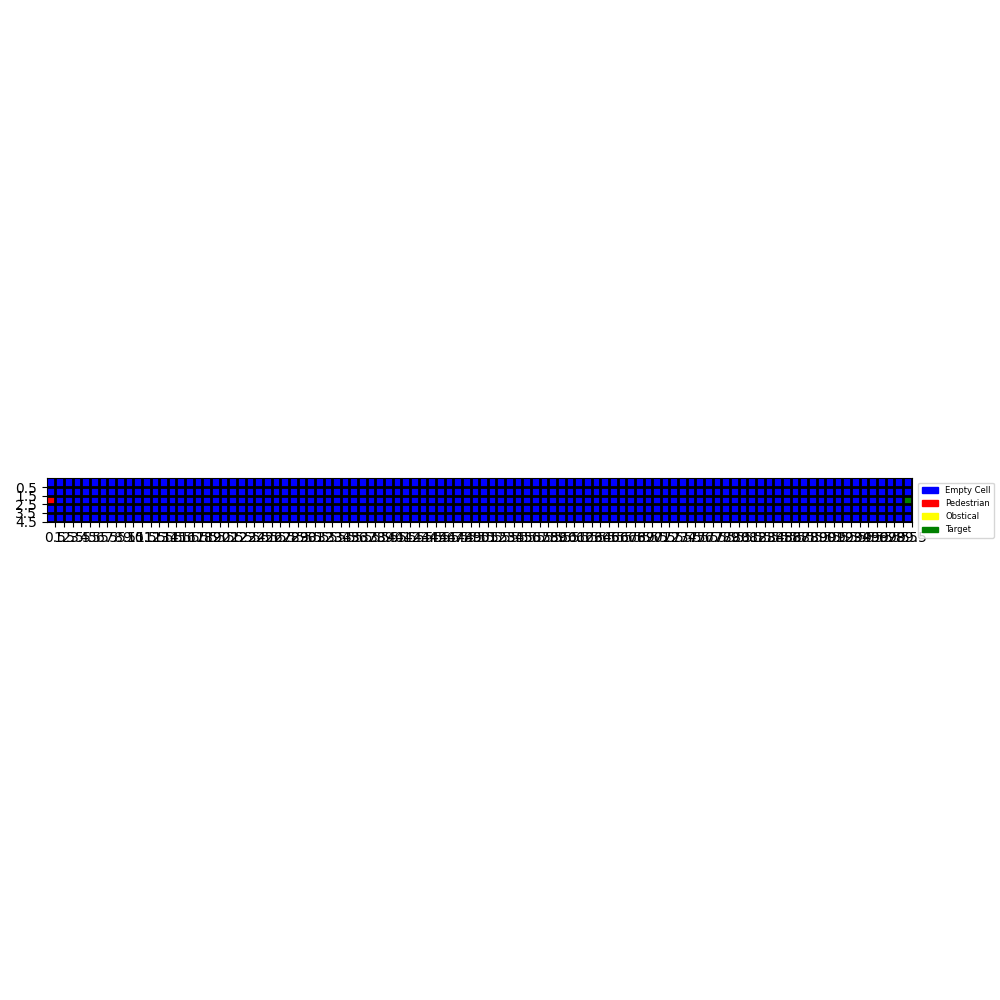

In [27]:
with open('./scenarios/rimea_test1.csv', newline='') as csvfile:
    rimea_1 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_1 = parser_array2obj(rimea_1)
visualize_state(rimea_1.to_array())

Here we can see the execution of the simulation. In order to see how much time it took for the pedestrian to move from one end to another, we can execute the same simulation with the help of the pygame GUI.

The simulation was took 99 steps and was executed in 29.7 seconds.


<IPython.core.display.Javascript object>


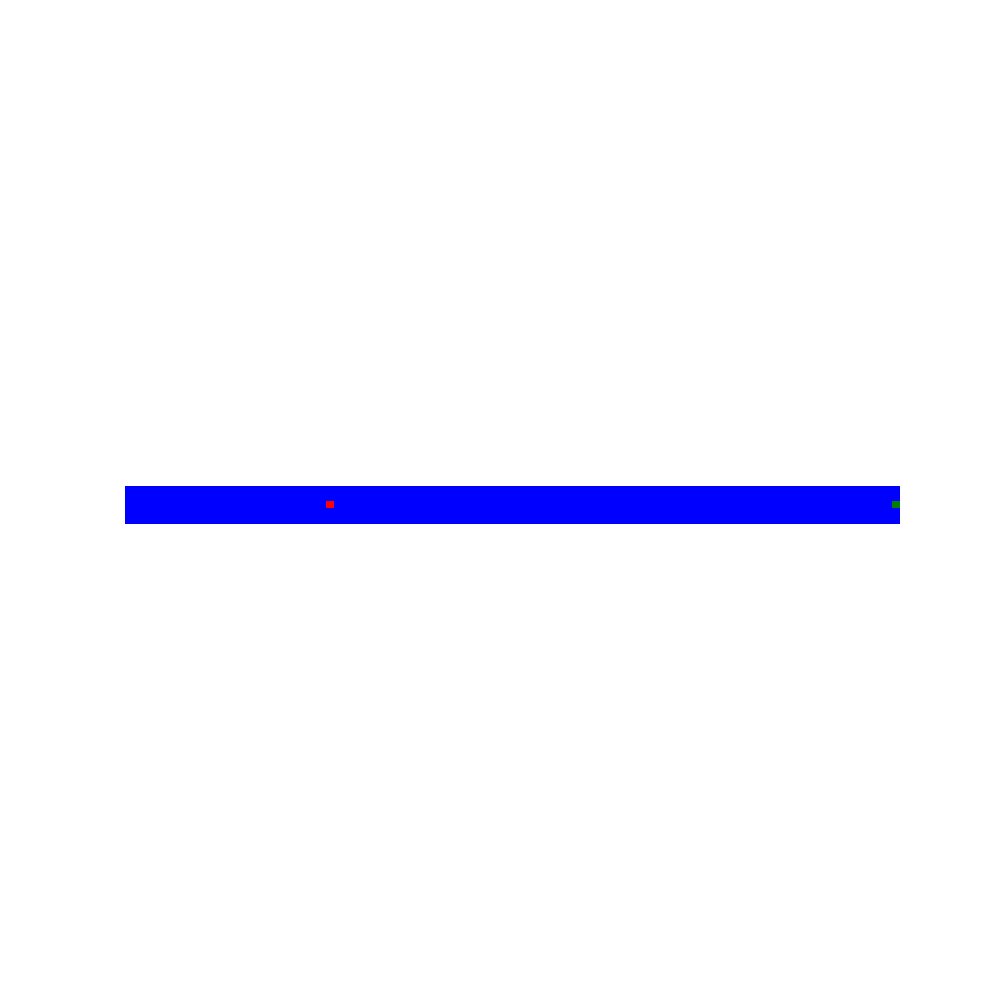

In [28]:
rimea_1.simulate(100)
rimea_1.animate()

### RiMEA 4



In [ ]:
with open('./scenarios/rimea_test4.csv', newline='') as csvfile:
    rimea_4 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_4 = parser_array2obj(rimea_4)
visualize_state(rimea_4.to_array())

### RiMEA 6
We simulate the passage of 20 pedestrians around a corner. The pedestrians must navigate while avoiding the obstacle which in this case is the entire wall.

<IPython.core.display.Javascript object>


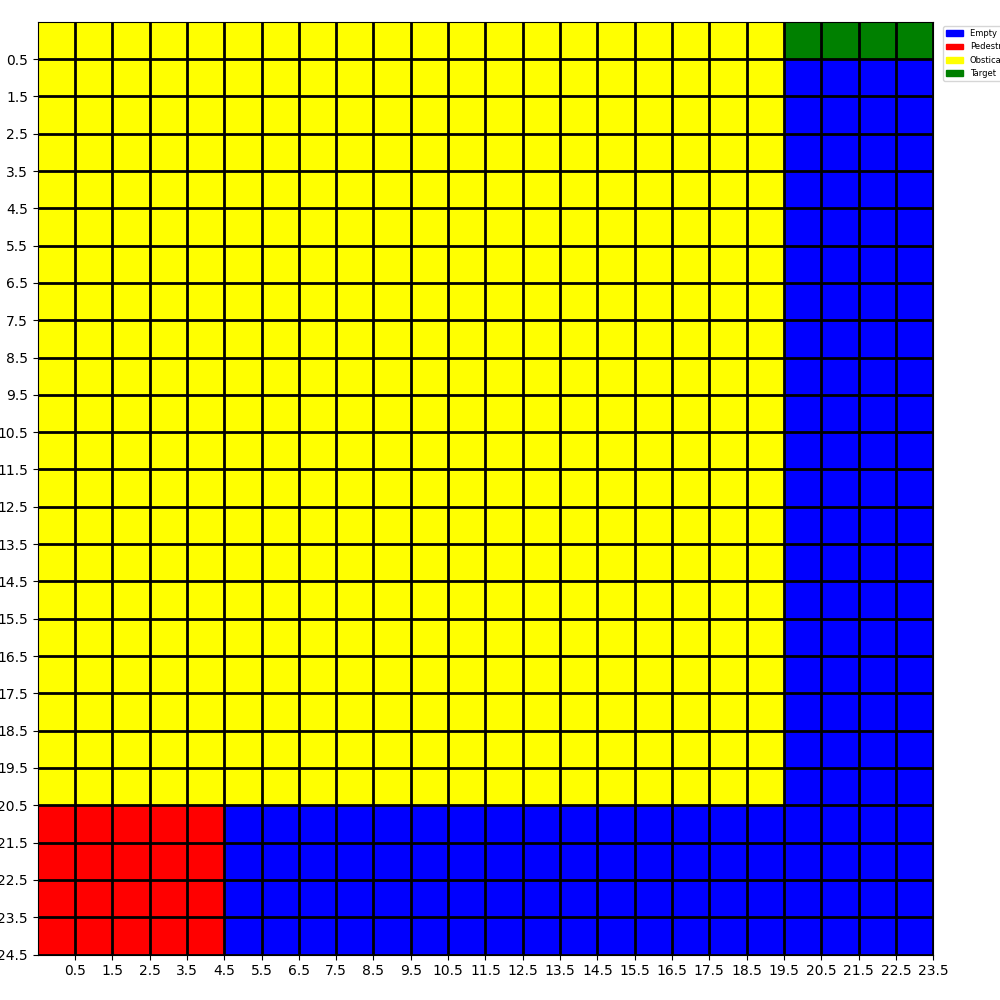

In [2]:
with open('./scenarios/rimea_test6.csv', newline='') as csvfile:
    rimea_6 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_6 = parser_array2obj(rimea_6)
visualize_state(rimea_6.to_array())

We can observe that the pedestrians can easily navigate around the corner and can also observe the repulsion between pedestrians.

The simulation was took 36 steps and was executed in 10.8 seconds.


<IPython.core.display.Javascript object>


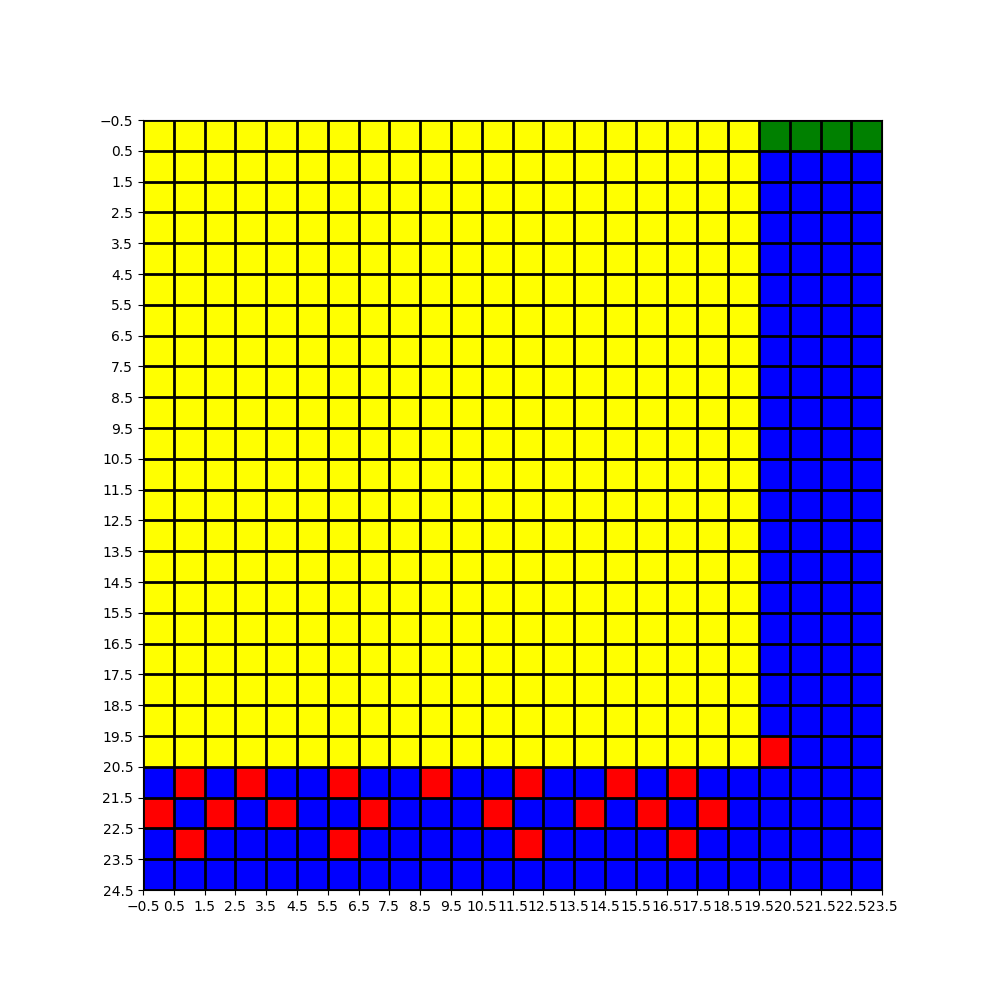

In [3]:
rimea_6.simulate(35)
rimea_6.animate()

### RiMEA 7